2022-09-15

1. EC를 추가

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + EC*(x**5)

2. 두가지 경우 비교

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + w5*(x**5)

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + EC*(x**5)

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + sigmoid* w *(x**5)

2022-09-20

loss =

[f(1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4)) - {w1 + 2*w2 + 3*w3*(x**2) + 4*w4*(x**3)}
 + f(EC)*(x**5) - {5*f(EC)*(x**4) + d_EC*(x**5)}]**2

 [f(1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4)) - {w1 + 2*w2 + 3*w3*(x**2) + 4*w4*(x**3)}]**2
 + [f(EC)*(x**5) - {5*f(EC)*(x**4) + d_EC*(x**5)}]**2

2022-09-29

Work 1

1 : ODE 4차 오차 감소율 없을때 출력

2 : ODE 5차 오차 감소율 없을때 출력

3 : ODE 4차 + EC Case1 w 계수들 exact 계수들과 일치하는 경우에 대해서 비교

2022-10-10

Exam 1

exp(-x)

Error, exact(4차, 5차), train(4차, 5차, 4차+EC Case1, Case2)

2022-10-12

EC 각 데이터별 학습

내적 부분 변경

데이터에 따라서 다른 값.

2022-10-16

NN + NN*x**2

2022-10-23

1_NN + 1_NN

2_NN + 1_NN

3_NN + 1_NN

Module import

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

Solve the following initial value differential equation $$ y'=\lambda y,  \quad  y(0)=y_0$$

Fuction Define

In [2]:
# analysis 함수 
def anal(x, lamb):
    return np.exp(lamb*x)

# n : w 개수, w : weight
def y(x, w, n = 4):
    y = 1         # y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4)
    for i in range(1, n+1):
        y += w[i-1]*(x**i)
    
    return y

def yprime(x, w, n = 4):
    yprime = 0    # yprime = w1 + 2*w2*x + 3*w3*(x**2) + 4*w4*(x**3)
    for i in range(1, n + 1):
        yprime += i*w[i-1]*(x**(i-1))

    return yprime

def f(y, lamb):
    return lamb*y

def sigmoid(x):
    return tf.math.sigmoid(x)

def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

def neural_network(W, x):
    a1 = sigmoid(tf.experimental.numpy.dot(x, W[0]))
    return tf.experimental.numpy.dot(a1, W[1])

def d_neural_network_dx(W, x, k=1):
    return tf.experimental.numpy.dot(tf.experimental.numpy.dot(tf.transpose(W[1]), tf.transpose(W[0])**k), sigmoid_grad(x))

def net_out(W, x):
    return neural_network(W, x)[0]

def EC_predict(W, x, n):
    return net_out(W, x)*x**(n+1)

def d_net_out(W, x):
    return d_neural_network_dx(W, x)

# 수정
def EC_d_y(W, x, n):
    return (n+1)*(x**n)*net_out(W, x)

# 2022-10-12 EC 수정
def new_EC(W, x, pos_x):
    return sigmoid(W[0][pos_x]*x)*W[1][pos_x]

def new_d_EC(W, x, pos_x):
    return W[0][pos_x]*W[1][pos_x]*sigmoid_grad(W[0][pos_x]*x)

def ECprime(w, W, x, base_n):
    yprime = 0    # yprime = w1 + 2*w2*x + 3*w3*(x**2) + 4*w4*(x**3)
    for i in range(1, base_n + 1):
        yprime += i*w[i-1]*(x**(i-1))
    else:
        yprime += (i+1)*net_out(W, x)*x**(i) + d_net_out(W, x)*x**(i+1)

    return yprime

def new_ECprime(w, W, x, pos_x, base_n):
    yprime = 0    # yprime = w1 + 2*w2*x + 3*w3*(x**2) + 4*w4*(x**3)
    for i in range(1, base_n + 1):
        yprime += i*w[i-1]*(x**(i-1))
    else:
        yprime += (i+1)*new_EC(W, x, pos_x)*x**(i) + new_d_EC(W, x, pos_x)*x**(i+1)

    return yprime


ODE

n : 차수

target_loss : 이전 학습 loss_sum의 차가 target_loss 보다 작으면 멈춤

early_stop : loss_sum 최소값 뒤로 최소값 갱신이 되지 않고, 정해진 값 이상 Epoch가 진행 되면 중단

learing_rate : 학습률

max_train_count : 최대 학습 횟수

In [3]:
def ODE_train(n = 4, target_loss = np.Inf, early_stop = np.Inf, max_train_count = np.Inf, show_w_trace = True, show_loss_trace = True, show_error = True, show_compare_analysis = True):
    # 최대 x 범위 : 0 <= x < x_max, lambda 값
    x_max = 1
    x_slice = 100
    x = tf.Variable(np.array([i/x_slice for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
    lamb = -1.0

    # 차수, weight 개수
    w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32), trainable=True) # w = [weight1, weight2, weight3, weight4, ... , weight(n)]

    # 변화 w 값, loss 저장
    w_trace = []
    w_trace.append(w.numpy())
    loss_trace = []

    # 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
    Epoch = 0

    # y' = f(y, t)를 만족하는 y 찾는 과정
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    # 학습 과정
    low_loss = np.inf
    low_loss_Epoch = 0
    while True:
        Epoch += 1
        loss_sum = 0.0
        for x_unit in x:
            with tf.GradientTape() as tape:
                # 예측 값
                predict = f(y(x_unit, w, n), lamb)
                # y' = f(y, t)
                loss = tf.square(predict - yprime(x_unit, w, n))
                loss_sum += loss

            # Gradient 값 저장
            gradients = tape.gradient(loss, w)
            # Gradient 값 w에 적용
            optimizer.apply_gradients(zip([gradients], [w]))
        
        # w 변화값 저장
        w_trace.append(w.numpy())

        # Epoch별 loss 합 저장
        loss_sum = float(loss_sum)
        loss_trace.append(loss_sum)
        
        # early stop
        if target_loss >= loss_sum and low_loss > loss_sum:
            low_loss = loss_sum
            early_stop_w = w
            low_loss_Epoch = Epoch
        
        if low_loss_Epoch != 0 and low_loss_Epoch + early_stop <= Epoch:
            print('early stop')
            break
        
        if np.isnan(loss_sum):
            print('break nan')
            break

        if Epoch % 100 == 0:
            print('Epoch : {}, Loss_sum : {:.4f}, w : {}'.format(Epoch, loss_sum, w.numpy()))

        if Epoch == max_train_count:
            print('max count')
            break
        
    print('low_loss_Epoch : {}, low_Loss_sum : {:.4f}, low_loss_w : {}'.format(low_loss_Epoch, low_loss, early_stop_w))

    if show_w_trace:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_title('Weight & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Weight')
        ax.plot(w_trace, label = ['w{}'.format(i+1) for i in range(n)])
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=10)
        ax.grid()

    if show_loss_trace:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_title('Loss & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.plot(loss_trace, label = 'loss')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_error:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.plot(abs(y(x, early_stop_w, n) - anal(x,lamb)), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_compare_analysis:
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.set_title('Analysis & f(lambda*y) & Error')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.plot(anal(x,lamb), label = 'analysis')
        ax.plot(y(x, early_stop_w, n), label = 'y')
        # ax.plot(y(x, w, n) + net_out(W)*x**5, label = 'add_EC')
        # ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    return early_stop_w, low_loss

In [4]:
def add_NN(n, trained_w, min_loss, target_loss = np.Inf, early_stop = np.Inf, max_train_count = np.Inf, show_w_trace = True, show_loss_trace = True, show_error = True, show_compare_analysis = True):
    # 최대 x 범위 : 0 <= x < x_max, lambda 값
    x_max = 1
    x_slice = 100
    x = tf.Variable(np.array([i/x_slice for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
    lamb = -1.0

    # 차수, weight 개수
    w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32), trainable=True) # w = [weight1, weight2, weight3, weight4, ... , weight(n)]
    t_w = trained_w

    # 변화 w 값, loss 저장
    w_trace = []
    total_w = tf.concat([t_w, w], 0)
    w_trace.append(total_w.numpy())
    loss_trace = []

    # 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
    Epoch = 0

    # y' = f(y, t)를 만족하는 y 찾는 과정
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    # 학습 과정
    low_loss = np.inf
    low_loss_Epoch = 0
    
    print('start_add_NN')
    while True:
        Epoch += 1
        loss_sum = 0.0
        for x_unit in x:
            with tf.GradientTape() as tape:
                # 예측 값
                total_w = tf.concat([t_w, w], 0)
                _y = y(x_unit, total_w, n = tf.size(total_w))
                predict = f(_y, lamb)
                y_prime = yprime(x_unit, total_w, n = tf.size(total_w))
                # y' = f(y, t)
                loss = tf.square(predict - y_prime)
                loss_sum += loss

            # Gradient 값 저장
            gradients = tape.gradient(loss, w)
            # Gradient 값 w에 적용
            optimizer.apply_gradients(zip([gradients], [w]))
        
        # w 변화값 저장
        w_trace.append(total_w.numpy())

        # Epoch별 loss 합 저장
        loss_sum = float(loss_sum)
        loss_trace.append(loss_sum)
        
        # early stop
        if min_loss > loss_sum and target_loss >= loss_sum and low_loss > loss_sum:
            low_loss = loss_sum
            early_stop_w = tf.concat([t_w, w], 0)
            low_loss_Epoch = Epoch
        
        if low_loss_Epoch != 0 and low_loss_Epoch + early_stop <= Epoch:
            print('early stop')
            break
        
        if np.isnan(loss_sum):
            print('break nan')
            break

        if Epoch % 100 == 0:
            print('Epoch : {}, Loss_sum : {:.4f}, w : {}'.format(Epoch, loss_sum, w.numpy()))

        if Epoch == max_train_count:
            print('max count')
            break

    print('low_loss_Epoch : {}, low_Loss_sum : {:.4f}, low_loss_w : {}'.format(low_loss_Epoch, low_loss, early_stop_w))

    if show_w_trace:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_title('Weight & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Weight')
        ax.plot(w_trace, label = ['w{}'.format(i+1) for i in range(n*2)])
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=10)
        ax.grid()

    if show_loss_trace:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_title('Loss & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.plot(loss_trace, label = 'loss')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_error:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.plot(abs(y(x, early_stop_w, n) - anal(x,lamb)), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_compare_analysis:
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.set_title('Analysis & f(lambda*y) & Error')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.plot(anal(x,lamb), label = 'analysis')
        ax.plot(y(x, early_stop_w, n), label = 'y')
        # ax.plot(y(x, w, n) + net_out(W)*x**5, label = 'add_EC')
        # ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()
    
    return early_stop_w, low_loss

In [ ]:
trained_data_1 = ODE_train(n = 1, early_stop = 500)
ODE_1tw_1w = add_NN(n = 1, trained_w = trained_data_1[0], min_loss = trained_data_1[1], early_stop = 500)

In [ ]:
trained_data_2 = ODE_train(n = 2, early_stop = 500)
ODE_2tw_1w = add_NN(n = 1, trained_w = trained_data_2[0], min_loss = trained_data_2[1], early_stop = 500)

In [ ]:
trained_data_3 = ODE_train(n = 3, early_stop = 500)
ODE_3tw_1w = add_NN(n = 1, trained_w = trained_data_3[0], min_loss = trained_data_3[1], early_stop = 500)

In [5]:
def add_EC(trained_w, min_loss, target_loss = np.Inf, early_stop = np.Inf, max_train_count = np.Inf, show_w_trace = True, show_loss_trace = True, show_error = True, show_compare_analysis = True):
    # 최대 x 범위 : 0 <= x < x_max, lambda 값
    x_max = 1
    x_slice = 100
    x = tf.Variable(np.array([i/x_slice for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
    lamb = -1.0

    # 차수, weight 개수
    EC_n = 10
    W = [tf.Variable(tf.random.normal(shape=(1, EC_n), dtype=tf.float32), trainable=True), 
    tf.Variable(tf.random.normal(shape=(EC_n, 1), dtype=tf.float32), trainable=True)] 
    EC = net_out(W, x[0])
    t_w = trained_w

    # 변화 w 값, loss 저장
    w_trace = []
    total_w = tf.concat([t_w, EC], 0)
    w_trace.append(total_w.numpy())
    loss_trace = []

    # 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
    Epoch = 0

    # y' = f(y, t)를 만족하는 y 찾는 과정
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    # 학습 과정
    low_loss = np.inf
    low_loss_Epoch = 0
    base_n = tf.size(t_w)
    print('start_add_NN')
    while True:
        Epoch += 1
        loss_sum = 0.0
        for x_unit in x:
            with tf.GradientTape() as tape:
                # 예측 값
                total_w = tf.concat([t_w, EC], 0)
                EC = net_out(W, x_unit)
                _y = y(x_unit, total_w, n = tf.size(total_w))
                predict = f(_y, lamb)
                y_prime = ECprime(t_w, W, x_unit, base_n)
                # y' = f(y, t)
                loss = tf.square(predict - y_prime)
                loss_sum += loss

            # Gradient 값 저장
            gradients = tape.gradient(loss, W)
            # Gradient 값 w에 적용
            optimizer.apply_gradients(zip([gradients[0], gradients[1]], [W[0], W[1]]))
        
        # w 변화값 저장
        w_trace.append(total_w.numpy())

        # Epoch별 loss 합 저장
        loss_sum = float(loss_sum)
        loss_trace.append(loss_sum)
        
        # early stop
        if min_loss > loss_sum and target_loss >= loss_sum and low_loss > loss_sum:
            low_loss = loss_sum
            early_stop_w = tf.concat([t_w, EC], 0)
            low_loss_Epoch = Epoch
        
        if low_loss_Epoch != 0 and low_loss_Epoch + early_stop <= Epoch:
            print('early stop')
            break
        
        if np.isnan(loss_sum):
            print('break nan')
            break

        if Epoch % 100 == 0:
            print('Epoch : {}, Loss_sum : {:.4f}, w : {}'.format(Epoch, loss_sum, EC.numpy()))

        if Epoch == max_train_count:
            print('max count')
            break

    print('low_loss_Epoch : {}, low_Loss_sum : {:.4f}, low_loss_w : {}'.format(low_loss_Epoch, low_loss, early_stop_w))

    if show_w_trace:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_title('Weight & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Weight')
        ax.plot(w_trace, label = ['w{}'.format(i+1) for i in range(tf.size(early_stop_w))])
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=10)
        ax.grid()

    if show_loss_trace:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_title('Loss & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.plot(loss_trace, label = 'loss')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_error:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.plot(abs(y(x, early_stop_w, tf.size(early_stop_w)) - anal(x,lamb)), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_compare_analysis:
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.set_title('Analysis & f(lambda*y) & Error')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.plot(anal(x,lamb), label = 'analysis')
        ax.plot(y(x, early_stop_w, tf.size(early_stop_w)), label = 'y')
        # ax.plot(y(x, w, n) + net_out(W)*x**5, label = 'add_EC')
        # ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()
    
    return early_stop_w, low_loss

In [ ]:
ODE_1tw_EC = add_EC(n = 1, trained_w = trained_data_1[0], min_loss = trained_data_1[1], early_stop = 500)

In [ ]:
ODE_2tw_EC = add_EC(n = 1, trained_w = trained_data_2[0], min_loss = trained_data_2[1], early_stop = 500)

In [ ]:
ODE_3tw_EC = add_EC(n = 1, trained_w = trained_data_3[0], min_loss = trained_data_3[1], early_stop = 500)

In [ ]:
early_stop_w = ODE_3tw_EC

# 최대 x 범위 : 0 <= x < x_max, lambda 값
x_max = 1
x_slice = 100
x = tf.Variable(np.array([i/x_slice for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
lamb = -1.0

fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title('Analysis & f(lambda*y) & Error')
ax.set_xlabel('x')
ax.set_ylabel('y')
# ax.plot(anal(x,lamb), label = 'analysis')
ax.plot(abs(y(x, early_stop_w, tf.size(early_stop_w)) - anal(x,lamb)), label = 'y')
ax.plot(abs(y(x, early_stop_w[:3], tf.size(early_stop_w[:3])) - anal(x,lamb)), label = 'y')
# ax.plot(y(x, w, n) + net_out(W)*x**5, label = 'add_EC')
# ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()

In [7]:
def add_EC_data(trained_w, target_loss = np.Inf, early_stop = np.Inf, max_train_count = np.Inf, show_w_trace = True, show_loss_trace = True, show_error = True, show_compare_analysis = True):
    # 최대 x 범위 : 0 <= x < x_max, lambda 값
    x_max = 1
    x_slice = 100
    x = tf.Variable(np.array([i/x_slice for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
    lamb = -1.0

    # 차수, weight 개수
    EC_n = tf.size(x)
    W = [tf.Variable(tf.random.normal(shape=(EC_n,1), dtype=tf.float32)), tf.Variable(tf.random.normal(shape=(EC_n,1), dtype=tf.float32))]
    EC = new_EC(W, x[0], 0)
    t_w = trained_w

    # 변화 w 값, loss 저장
    w_trace = []
    total_w = tf.concat([t_w, EC], 0)
    w_trace.append(total_w.numpy())
    loss_trace = []

    # 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
    Epoch = 0

    # y' = f(y, t)를 만족하는 y 찾는 과정
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    # 학습 과정
    low_loss = np.inf
    low_loss_Epoch = 0
    base_n = tf.size(t_w)
    print('start_add_NN')
    while True:
        Epoch += 1
        loss_sum = 0.0
        for idx, x_unit in enumerate(x):
            with tf.GradientTape() as tape:
                # 예측 값
                EC = new_EC(W, x_unit, idx)
                total_w = tf.concat([t_w, EC], 0)
                _y = y(x_unit, total_w, n = tf.size(total_w))
                predict = f(_y, lamb)
                y_prime = new_ECprime(t_w, W, x_unit, idx, base_n)
                # y' = f(y, t)
                loss = tf.square(predict - y_prime)
                loss_sum += loss

            # Gradient 값 저장
            gradients = tape.gradient(loss, W)
            # Gradient 값 w에 적용
            optimizer.apply_gradients(zip([gradients[0], gradients[1]], [W[0], W[1]]))
        
        # w 변화값 저장
        w_trace.append(total_w.numpy())

        # Epoch별 loss 합 저장
        loss_sum = float(loss_sum)
        loss_trace.append(loss_sum)
        
        # early stop
        if target_loss >= loss_sum and low_loss > loss_sum:
            low_loss = loss_sum
            early_stop_w = t_w, W
            low_loss_Epoch = Epoch
        
        if low_loss_Epoch != 0 and low_loss_Epoch + early_stop <= Epoch:
            print('early stop')
            break
        
        if np.isnan(loss_sum):
            print('break nan')
            break

        if Epoch % 100 == 0:
            print('Epoch : {}, Loss_sum : {:.4f}, w : {}'.format(Epoch, loss_sum, EC.numpy()))

        if Epoch == max_train_count:
            print('max count')
            break

    print('low_loss_Epoch : {}, low_Loss_sum : {:.4f}, low_loss_w : {}'.format(low_loss_Epoch, low_loss, early_stop_w))
    
    return early_stop_w, low_loss

In [ ]:
train = ODE_train(n = 3, early_stop = 500)[0]

In [ ]:
ODE_3tw_dataEC = add_EC_data(trained_w = train, early_stop = 500)

early stop
low_loss_Epoch : 13, low_Loss_sum : 3.8050, low_loss_w : <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([-0.6309707], dtype=float32)>
start_add_NN
Epoch : 100, Loss_sum : 10.1659, w : [0.08036129]
Epoch : 200, Loss_sum : 1.4732, w : [0.08048967]
Epoch : 300, Loss_sum : 0.5293, w : [0.08048967]
Epoch : 400, Loss_sum : 0.4009, w : [0.08048967]
Epoch : 500, Loss_sum : 0.3498, w : [0.08048967]
Epoch : 600, Loss_sum : 0.3139, w : [0.08048967]
Epoch : 700, Loss_sum : 0.2862, w : [0.08048967]
Epoch : 800, Loss_sum : 0.2622, w : [0.08048967]
Epoch : 900, Loss_sum : 0.2419, w : [0.08048967]
Epoch : 1000, Loss_sum : 0.2256, w : [0.08048967]
Epoch : 1100, Loss_sum : 0.2136, w : [0.08048967]
Epoch : 1200, Loss_sum : 0.2045, w : [0.08048967]
Epoch : 1300, Loss_sum : 0.1969, w : [0.08048967]
Epoch : 1400, Loss_sum : 0.1908, w : [0.08048967]
Epoch : 1500, Loss_sum : 0.1855, w : [0.08048967]
Epoch : 1600, Loss_sum : 0.1805, w : [0.08048967]
Epoch : 1700, Loss_sum : 0.1757, 

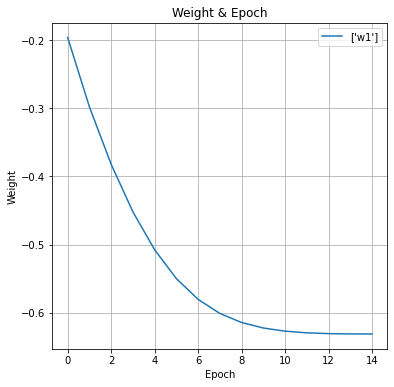

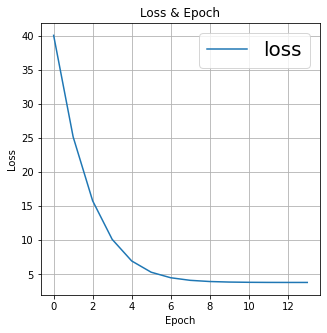

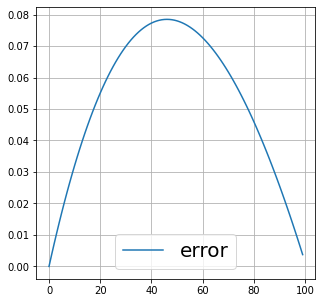

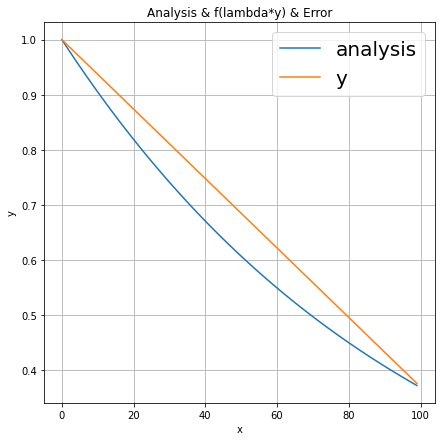

In [27]:
train_1 = ODE_train(n = 1, early_stop = 1)
ODE_1tw_dataEC = add_EC_data(trained_w = train_1[0], max_train_count=1200)

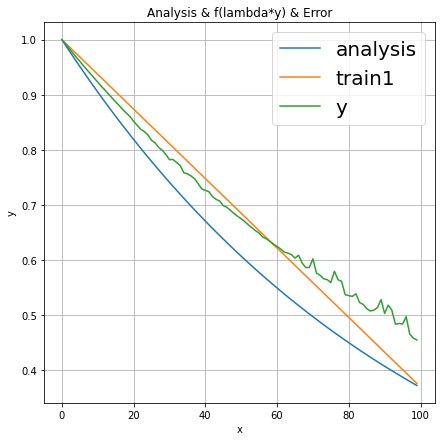

In [29]:
x_max = 1
x_slice = 100
x = tf.Variable(np.array([i/x_slice for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
lamb = -1.0

w, W = ODE_1tw_dataEC[0][0], ODE_1tw_dataEC[0][1]

    
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title('Analysis & f(lambda*y) & Error')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(anal(x,lamb), label = 'analysis')
ax.plot(y(x, train_1[0], 1), label = 'train1')
ax.plot([y(x_unit, tf.concat([w, new_EC(W, x_unit, idx)], 0), 2) for idx, x_unit in enumerate(x)], label = 'y')
# ax.plot(abs([y(x_unit, tf.concat([w, new_EC(W, x_unit, idx)], 0), 2) for idx, x_unit in enumerate(x)] - anal(x,lamb)), label = 'error')

ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()

Epoch : 100, Loss_sum : 0.0807, w : [-0.93207705  0.29738528]
early stop
low_loss_Epoch : 93, low_Loss_sum : 0.0765, low_loss_w : <tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([-0.92309076,  0.28566685], dtype=float32)>
start_add_NN
Epoch : 100, Loss_sum : 14.1001, w : [-0.0074897]
Epoch : 200, Loss_sum : 0.7062, w : [-0.00215472]
Epoch : 300, Loss_sum : 0.0416, w : [-0.00215472]
Epoch : 400, Loss_sum : 0.0256, w : [-0.00215472]
Epoch : 500, Loss_sum : 0.0237, w : [-0.00215472]
Epoch : 600, Loss_sum : 0.0225, w : [-0.00215472]
Epoch : 700, Loss_sum : 0.0215, w : [-0.00215472]
Epoch : 800, Loss_sum : 0.0206, w : [-0.00215472]
Epoch : 900, Loss_sum : 0.0199, w : [-0.00215472]
Epoch : 1000, Loss_sum : 0.0192, w : [-0.00215472]
Epoch : 1100, Loss_sum : 0.0186, w : [-0.00215472]
Epoch : 1200, Loss_sum : 0.0180, w : [-0.00215472]
Epoch : 1300, Loss_sum : 0.0176, w : [-0.00215472]
Epoch : 1400, Loss_sum : 0.0171, w : [-0.00215472]
Epoch : 1500, Loss_sum : 0.0167, w : [-0.002

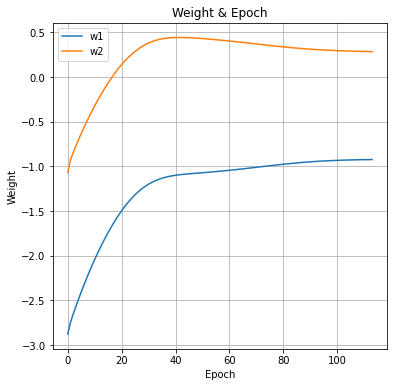

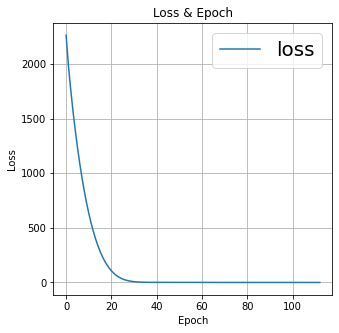

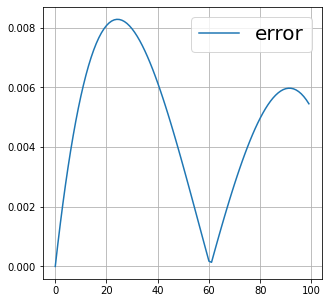

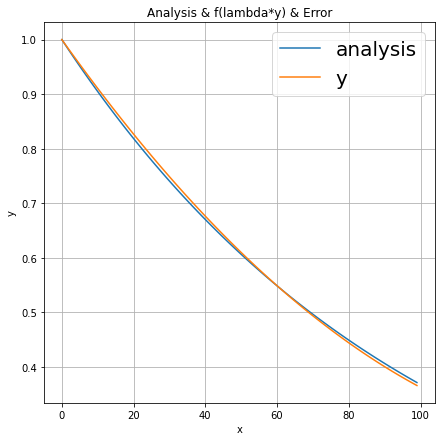

In [30]:
train_2 = ODE_train(n = 2, early_stop = 20)
ODE_2tw_dataEC = add_EC_data(trained_w = train_2[0], max_train_count=10000)

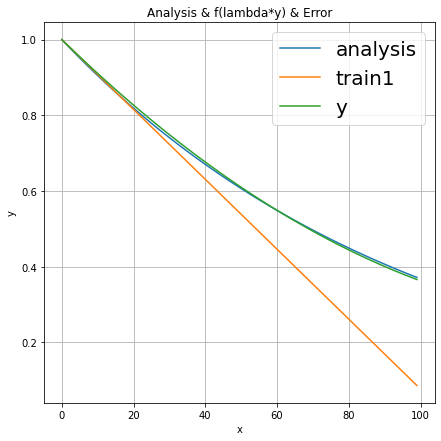

In [31]:
x_max = 1
x_slice = 100
x = tf.Variable(np.array([i/x_slice for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
lamb = -1.0

w, W = ODE_2tw_dataEC[0][0], ODE_2tw_dataEC[0][1]

    
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title('Analysis & f(lambda*y) & Error')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(anal(x,lamb), label = 'analysis')
ax.plot(y(x, train_2[0], 1), label = 'train1')
ax.plot([y(x_unit, tf.concat([w, new_EC(W, x_unit, idx)], 0), 2) for idx, x_unit in enumerate(x)], label = 'y')
# ax.plot(abs([y(x_unit, tf.concat([w, new_EC(W, x_unit, idx)], 0), 2) for idx, x_unit in enumerate(x)] - anal(x,lamb)), label = 'error')

ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()

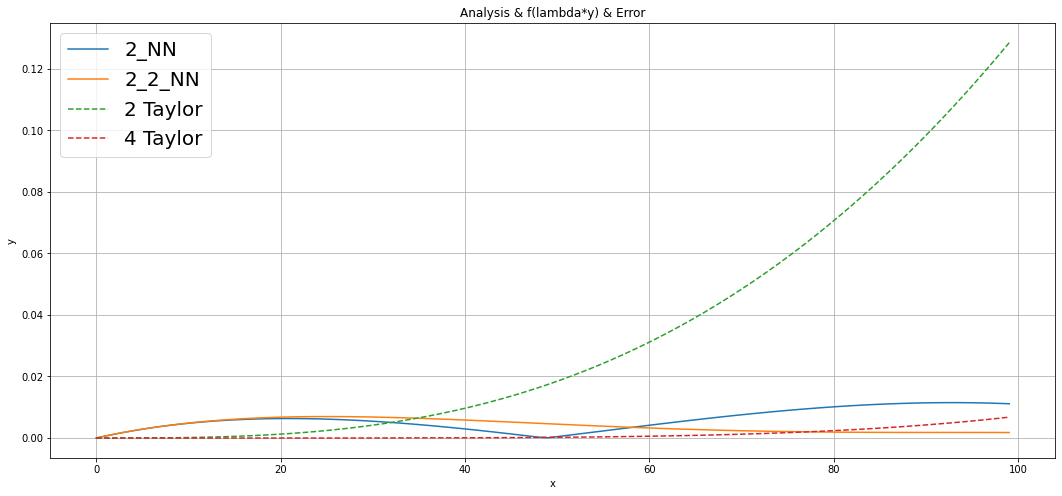

In [42]:
x_max = 1
x_slice = 100
x = tf.Variable(np.array([[i/x_slice] for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
lamb = -1.0

_w = ODE_2tw_2w

n = 2

poly_w = [-1, 1/2, -1/6, 1/24, -1/120]

fig, ax = plt.subplots(figsize=(18, 8))
ax.set_title('Analysis & f(lambda*y) & Error')
ax.set_xlabel('x')
ax.set_ylabel('y')
# ax.plot(anal(x,lamb), label = 'Exact')
ax.plot(abs(y(x, _w, 2) - anal(x,lamb)), label = '2_NN')
ax.plot(abs(y(x, _w, 4) - anal(x,lamb)), label = '2_2_NN')
ax.plot(abs(y(x, poly_w[:2], 2) - anal(x,lamb)), '--', label = '2 Taylor')
ax.plot(abs(y(x, poly_w[:4], 4) - anal(x,lamb)), '--', label = '4 Taylor')

ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()

In [32]:
# x**2
# y(x, _t_w, 2)

<tf.Tensor: shape=(100, 1), dtype=float32, numpy=
array([[1.        ],
       [0.990703  ],
       [0.9814639 ],
       [0.97228265],
       [0.96315926],
       [0.9540939 ],
       [0.9450863 ],
       [0.93613666],
       [0.92724496],
       [0.9184111 ],
       [0.90963507],
       [0.90091705],
       [0.89225686],
       [0.88365453],
       [0.8751101 ],
       [0.86662364],
       [0.858195  ],
       [0.84982437],
       [0.8415115 ],
       [0.8332566 ],
       [0.82505953],
       [0.8169204 ],
       [0.80883914],
       [0.8008159 ],
       [0.7928504 ],
       [0.7849428 ],
       [0.7770932 ],
       [0.76930135],
       [0.7615675 ],
       [0.7538915 ],
       [0.74627346],
       [0.7387132 ],
       [0.7312109 ],
       [0.72376645],
       [0.71638   ],
       [0.70905143],
       [0.7017807 ],
       [0.6945678 ],
       [0.68741286],
       [0.68031585],
       [0.67327666],
       [0.66629547],
       [0.6593721 ],
       [0.6525066 ],
       [0.645699  ],
     

ODE + EC

n : 차수

EC_n : EC weight 개수 (가로, 세로 두 곳 다 적용)

target_loss : loss_sum이 target_loss 보다 작아지면 early_stop 조건에 들어간다. 

early_stop : loss_sum 최소값 뒤로 최소값 갱신이 되지 않고, 정해진 값 이상 Epoch가 진행 되면 중단

learing_rate : 학습률

max_train_count : 최대 학습 횟수

In [155]:
def ODE_EC_Case1_train(n = 4, target_loss = np.Inf, early_stop = np.Inf, max_train_count = np.Inf, show_w_trace = True, show_loss_trace = True, show_error = True, show_compare_analysis = True):
    # 최대 x 범위 : 0 <= x < x_max, lambda 값
    x_max = 1
    x_slice = 100
    x = tf.Variable(np.array([i/x_slice for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
    lamb = -1.0

    # 차수, weight 개수
    w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32), trainable=True) # w = [weight1, weight2, weight3, weight4]

    # EC, Weight 개수
    # W = [[EC_n], [EC_n]]
    EC_n = len(list(x))
    W = [[tf.Variable(tf.random.normal(shape=(1,), dtype=tf.float32), trainable=True) for _ in range(EC_n)], 
    [tf.Variable(tf.random.normal(shape=(1,), dtype=tf.float32), trainable=True) for _ in range(EC_n)]] 

    # 변화 w 값, loss 저장
    w_trace = []
    w_trace.append(w.numpy())
    loss_trace = []

    # 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
    Epoch = 0
    
    # y' = f(y, t)를 만족하는 y 찾는 과정
    EC_optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    # 학습 과정
    low_loss = np.inf
    low_loss_Epoch = 0
    while True:
        Epoch += 1
        loss_sum = 0.0
        for idx, x_unit in enumerate(x):
            with tf.GradientTape() as tape:
                # 예측 값
                _y = y(x_unit, w, n) + new_EC(W, x_unit, idx)*x_unit**(n+1)
                predict = f(_y, lamb)
                y_prime = yprime(x_unit, w, n) + 4*new_EC(W, x_unit, idx)*x_unit**n + new_d_EC(W, x_unit, idx)*x_unit**(n+1)
                # y' = f(y, t)
                loss = tf.square(predict - y_prime)
                loss_sum += loss
            
            # Gradient 값 저장
            [gradients, EC_W0_gradients, EC_W1_gradients] = tape.gradient(loss, [w, W[0][idx], W[1][idx]])
            # Gradient 값 w에 적용
            EC_optimizer.apply_gradients(zip([gradients, EC_W0_gradients, EC_W1_gradients], [w, W[0][idx], W[1][idx]]))
            
        # w 변화값 저장
        w_trace.append(w.numpy())

        # Epoch별 loss 합 저장
        loss_sum = float(loss_sum)
        loss_trace.append(loss_sum)

        # early stop
        if target_loss >= loss_sum and  low_loss > loss_sum:
            low_loss = loss_sum
            early_stop_w = w, [[w[0] for w in W[0]], [w[0] for w in W[1]]]
            low_loss_Epoch = Epoch
        
        if low_loss_Epoch + early_stop <= Epoch:
            print('early_stop')
            break

        if np.isnan(loss_sum):
            print('break nan')
            break
        
        if Epoch % 100 == 0:
            print('Epoch : {}, Loss_sum : {:.4f}, w : {}'.format(Epoch, loss_sum, w.numpy()))

        if Epoch == max_train_count:
            print('max count')
            break
        
    print('low_loss_Epoch : {}, low_Loss_sum : {:.4f}, low_loss_w : {}'.format(low_loss_Epoch, low_loss, early_stop_w[0]))

    if show_w_trace:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_title('Weight & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Weight')
        ax.plot(w_trace, label = ['w{}'.format(i+1) for i in range(n)])
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=10)
        ax.grid()
    
    if show_loss_trace:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_title('Loss & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.plot(loss_trace, label = 'loss')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_error:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.plot(abs(y(x, early_stop_w[0], n) + sigmoid(early_stop_w[1][0]*x)*early_stop_w[1][1]*x**(n+1) - anal(x,lamb)), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_compare_analysis:
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.set_title('Analysis & f(lambda*y) & Error')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.plot(anal(x,lamb), label = 'analysis')
        # ax.plot(y(x, w, n), label = 'y')
        ax.plot(y(x, early_stop_w[0], n) + sigmoid(early_stop_w[1][0]*x)*early_stop_w[1][1]*x**(n+1), label = 'add_EC')
        # ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    return early_stop_w

In [156]:
def ODE_EC_Case2_train(n = 4, target_loss = np.Inf, early_stop = np.Inf, max_train_count = np.Inf, show_w_trace = True, show_loss_trace = True, show_error = True, show_compare_analysis = True):
    # 최대 x 범위 : 0 <= x < x_max, lambda 값
    x_max = 1
    x_slice = 100
    x = tf.Variable(np.array([i/x_slice for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
    lamb = -1.0

    # 차수, weight 개수
    w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32), trainable=True) # w = [weight1, weight2, weight3, weight4]

    # EC, Weight 개수
    # W = [[EC_n], [EC_n]]
    EC_n = len(list(x))
    W = [[tf.Variable(tf.random.normal(shape=(1,), dtype=tf.float32), trainable=True) for _ in range(EC_n)], 
    [tf.Variable(tf.random.normal(shape=(1,), dtype=tf.float32), trainable=True) for _ in range(EC_n)]] 
    
    # 변화 w 값, loss 저장
    w_trace = []
    w_trace.append(w.numpy())
    loss_trace = []

    # 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
    Epoch = 0
    
    # y' = f(y, t)를 만족하는 y 찾는 과정
    EC_optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    # 학습 과정
    low_loss = np.inf
    low_loss_Epoch = 0
    while True:
        Epoch += 1
        loss_sum = 0.0
        for idx, x_unit in enumerate(x):
            with tf.GradientTape() as tape:
                # 예측 값
                _y = y(x_unit, w, n)
                EC = new_EC(W, x_unit, idx)
                predict = f(_y, lamb)
                y_prime = yprime(x_unit, w, n)
                d_EC = new_d_EC(W, x_unit, idx)
                # y' = f(y, t)
                loss = tf.square(predict - yprime(x_unit, w, n)) + tf.square(EC - d_EC)
                loss_sum += loss
            
            # Gradient 값 저장
            [gradients, EC_W0_gradients, EC_W1_gradients] = tape.gradient(loss, [w, W[0][idx], W[1][idx]])
            # Gradient 값 w에 적용
            EC_optimizer.apply_gradients(zip([gradients, EC_W0_gradients, EC_W1_gradients], [w, W[0][idx], W[1][idx]]))
            
        # w 변화값 저장
        w_trace.append(w.numpy())

        # Epoch별 loss 합 저장
        loss_sum = float(loss_sum)
        loss_trace.append(loss_sum)

        # early stop
        if target_loss >= loss_sum and  low_loss > loss_sum:
            low_loss = loss_sum
            early_stop_w = w, [[w[0] for w in W[0]], [w[0] for w in W[1]]]
            low_loss_Epoch = Epoch
        
        if low_loss_Epoch + early_stop <= Epoch:
            print('early_stop')
            break

        if np.isnan(loss_sum):
            print('break nan')
            break
        
        if Epoch % 100 == 0:
            print('Epoch : {}, Loss_sum : {:.4f}, w : {}'.format(Epoch, loss_sum, w.numpy()))

        if Epoch == max_train_count:
            print('max count')
            break
        
    print('low_loss_Epoch : {}, low_Loss_sum : {:.4f}, low_loss_w : {}'.format(low_loss_Epoch, low_loss, early_stop_w[0]))

    if show_w_trace:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_title('Weight & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Weight')
        ax.plot(w_trace, label = ['w{}'.format(i+1) for i in range(n)])
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=10)
        ax.grid()
    
    if show_loss_trace:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_title('Loss & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.plot(loss_trace, label = 'loss')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_error:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.plot(abs(y(x, early_stop_w[0], n) + sigmoid(early_stop_w[1][0]*x)*early_stop_w[1][1]*x**(n+1) - anal(x,lamb)), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_compare_analysis:
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.set_title('Analysis & f(lambda*y) & Error')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.plot(anal(x,lamb), label = 'analysis')
        # ax.plot(y(x, w, n), label = 'y')
        ax.plot(y(x, early_stop_w[0], n) + sigmoid(early_stop_w[1][0]*x)*early_stop_w[1][1]*x**(n+1), label = 'add_EC')
        # ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    return early_stop_w

Train

----------------------------------

Epoch : 100, Loss_sum : 10.3174, w : [-0.65039337 -0.20276804  0.23884206]
Epoch : 200, Loss_sum : 3.0027, w : [-0.8752517   0.2057551   0.03357137]
Epoch : 300, Loss_sum : 0.3721, w : [-0.977782    0.42951816 -0.08331487]
Epoch : 400, Loss_sum : 0.1040, w : [-0.9949222   0.45865145 -0.09658359]
Epoch : 500, Loss_sum : 0.2069, w : [-0.98853004  0.45225388 -0.09534408]
Epoch : 600, Loss_sum : 0.0985, w : [-0.9957085   0.45855656 -0.09594629]
Epoch : 700, Loss_sum : 0.1483, w : [-0.9941705   0.46108353 -0.09752053]
Epoch : 800, Loss_sum : 0.1853, w : [-0.9900315   0.4589705  -0.09963944]
early stop
low_loss_Epoch : 372, low_Loss_sum : 0.0571, low_loss_w : <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([-0.99550647,  0.45917338, -0.09606724], dtype=float32)>


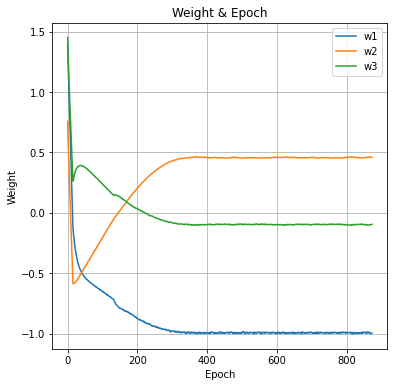

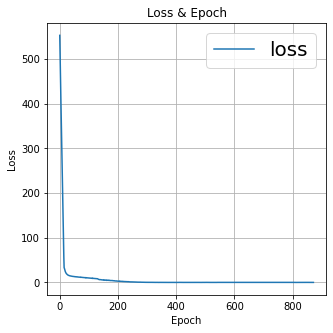

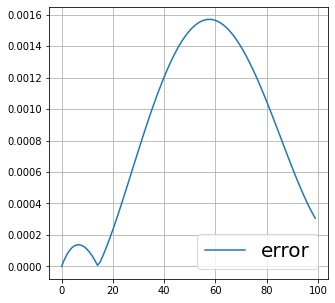

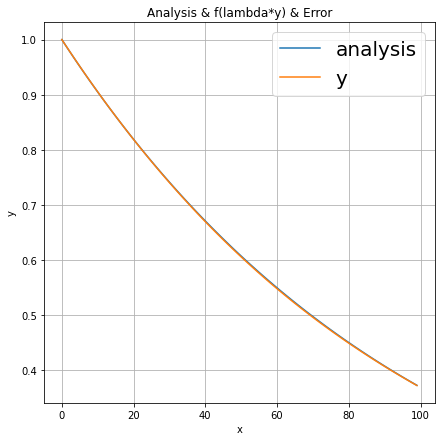

In [157]:
w3_train = ODE_train(n = 3, early_stop = 500)

Epoch : 100, Loss_sum : 12.9730, w : [-1.3802524   1.079366   -0.25755918 -0.09994458]
Epoch : 200, Loss_sum : 0.8752, w : [-1.0453557   0.67060965 -0.36615953  0.11041068]
Epoch : 300, Loss_sum : 0.4554, w : [-1.020319   0.6203918 -0.3324259  0.101252 ]
Epoch : 400, Loss_sum : 0.3135, w : [-1.0135851   0.5950576  -0.29506993  0.08464313]
Epoch : 500, Loss_sum : 0.3955, w : [-1.0246075   0.5746337  -0.26092622  0.07295389]
Epoch : 600, Loss_sum : 0.3643, w : [-1.0199744   0.5595638  -0.23191361  0.05707711]
break nan
low_loss_Epoch : 693, low_Loss_sum : 0.0895, low_loss_w : <tf.Variable 'Variable:0' shape=(4,) dtype=float32, numpy=array([nan, nan, nan, nan], dtype=float32)>


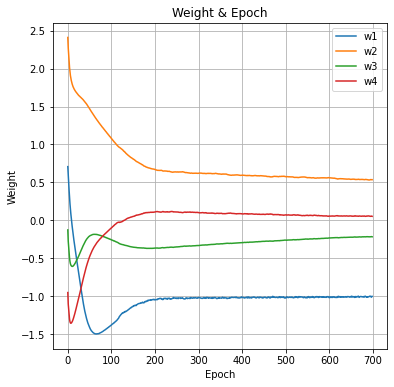

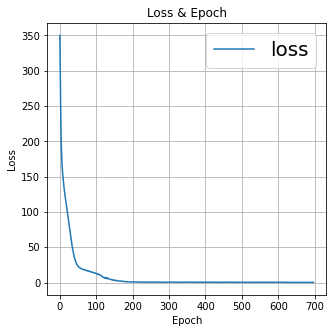

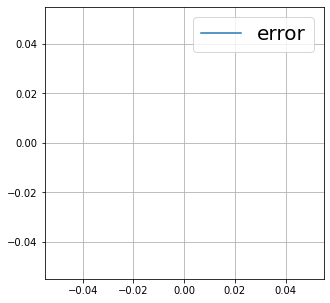

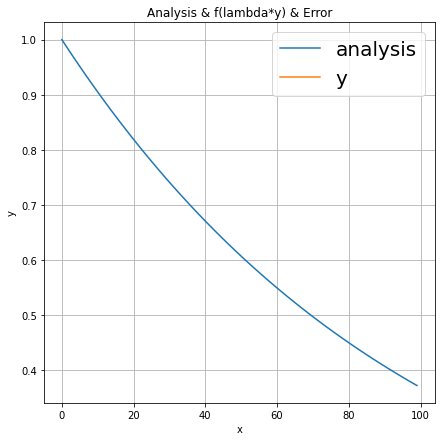

In [162]:
w4_train = ODE_train(n = 4, early_stop = 500)

Epoch : 100, Loss_sum : 16.5980, w : [-1.5847691  2.460066  -1.5646889]
Epoch : 200, Loss_sum : 10.1442, w : [-1.5432998  2.253737  -1.3998448]
Epoch : 300, Loss_sum : 6.8907, w : [-1.4615318  2.0123258 -1.2372428]
Epoch : 400, Loss_sum : 4.8150, w : [-1.3798152  1.776425  -1.0796356]
Epoch : 500, Loss_sum : 3.4235, w : [-1.3063172  1.5623711 -0.9354131]
Epoch : 600, Loss_sum : 2.4784, w : [-1.2437843   1.376955   -0.80886424]
Epoch : 700, Loss_sum : 1.8296, w : [-1.1925564  1.2214333 -0.7010894]
Epoch : 800, Loss_sum : 1.3774, w : [-1.1516765  1.0937842 -0.6111494]
Epoch : 900, Loss_sum : 1.0564, w : [-1.1195899   0.9903544  -0.53701204]
Epoch : 1000, Loss_sum : 0.8238, w : [-1.0946339  0.9070583 -0.4762759]
Epoch : 1100, Loss_sum : 0.6518, w : [-1.0752779   0.84002435 -0.4265838 ]
Epoch : 1200, Loss_sum : 0.5223, w : [-1.060236    0.78591317 -0.3858479 ]
Epoch : 1300, Loss_sum : 0.4229, w : [-1.0484865   0.74201345 -0.3523327 ]
Epoch : 1400, Loss_sum : 0.3455, w : [-1.0392522   0.706

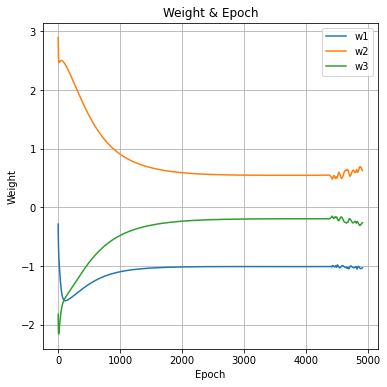

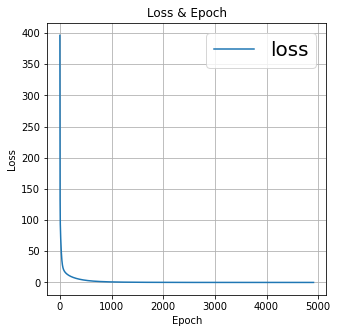

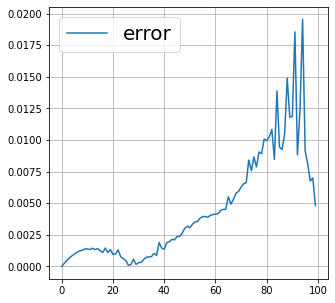

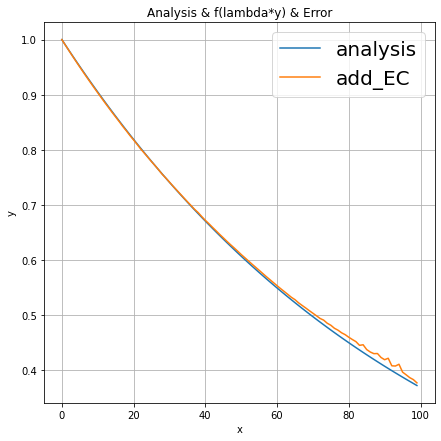

In [159]:
w3_EC_Case1_train = ODE_EC_Case1_train(n = 3, early_stop = 500)

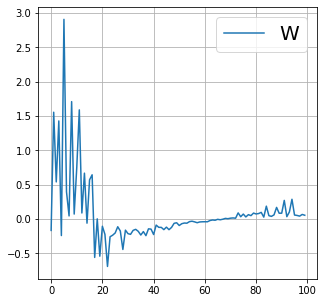

In [163]:
w, W = w3_EC_Case1_train

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(W[1], label = 'W')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()

In [164]:
w3_EC_Case2_train = ODE_EC_Case2_train(n = 3, early_stop = 500)

Epoch : 100, Loss_sum : 14.4158, w : [-1.1505548   0.82115614 -0.30364084]
Epoch : 200, Loss_sum : 8.7972, w : [-0.9970534   0.46878666 -0.10306064]
Epoch : 300, Loss_sum : 6.1776, w : [-0.9950649   0.4671579  -0.10292181]
Epoch : 400, Loss_sum : 4.5842, w : [-0.9971938   0.47199517 -0.10535017]
Epoch : 500, Loss_sum : 3.5129, w : [-0.9924638  0.4615018 -0.1002704]
Epoch : 600, Loss_sum : 2.7516, w : [-0.9951077   0.46600568 -0.10080116]
Epoch : 700, Loss_sum : 2.1875, w : [-0.99803966  0.4680336  -0.10239696]
Epoch : 800, Loss_sum : 1.7578, w : [-0.9952183  0.4721306 -0.1069102]
Epoch : 900, Loss_sum : 1.4230, w : [-0.99906254  0.4684435  -0.1019284 ]
Epoch : 1000, Loss_sum : 1.1583, w : [-0.99469167  0.45762414 -0.0963482 ]
Epoch : 1100, Loss_sum : 0.9459, w : [-0.9900014  0.4655361 -0.1043729]
Epoch : 1200, Loss_sum : 0.7743, w : [-0.99518996  0.46619192 -0.10187452]
Epoch : 1300, Loss_sum : 0.6341, w : [-0.99737734  0.4670097  -0.10194724]
Epoch : 1400, Loss_sum : 0.5193, w : [-0.9

In [ ]:
# 2022.07.20
# 에러 그래프 부분 보강
# epoch 늘려서 학습 결과 찾기
# w 값 
# w1 = lambda와 비슷하게 -2
# w2 = 2
# w3 = -1
# w4 = 0.5
# layer 구조 확인

# 2022.08.03
# 모델 부분 input -> layer -> layer -> output
# layer 추가 할 수 있게 만들어 놓기

# 2022.08.23
# x 범위 증가 대신 개수 증가로 0 ~ 1 사이
# 코드 공유
# Error 파트 layer 추가
# Solution + Error
##  추가 학습 필요 내용 ## 
# Error에 따른 weight 업데이트 과정 수식 확인
# 비지도 학습 진행과정


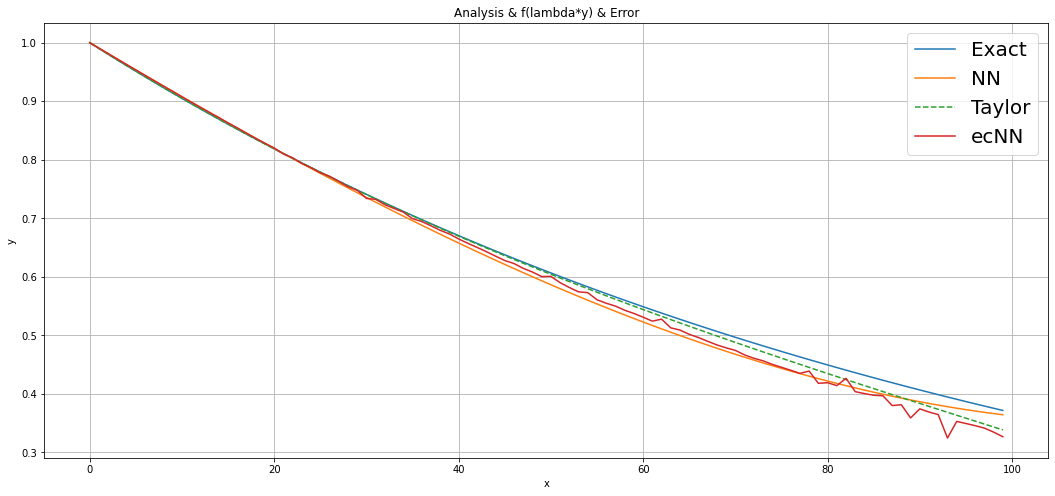

In [ ]:
x_max = 1
x_slice = 100
x = tf.Variable(np.array([[i/x_slice] for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
lamb = -1.0

w, W = w3_EC_Case1_train

n = 3

poly_w = [-1, 1/2, -1/6, 1/24, -1/120]

fig, ax = plt.subplots(figsize=(18, 8))
ax.set_title('Analysis & f(lambda*y) & Error')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(anal(x,lamb), label = 'Exact')
# ax.plot(y(x, w, n), label = 'NN')
ax.plot(y(x, poly_w[:n], n), '--', label = 'Taylor')
ax.plot(y(x, w, n) + [sigmoid(w0*x_unit)*w1*x_unit**(n+1) for x_unit, w0, w1 in zip(x, *W)], label = 'ecNN')

# ax.plot(y(x, w, n)  + EC_predict(W, x, n), label = 'add_EC')
# ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()

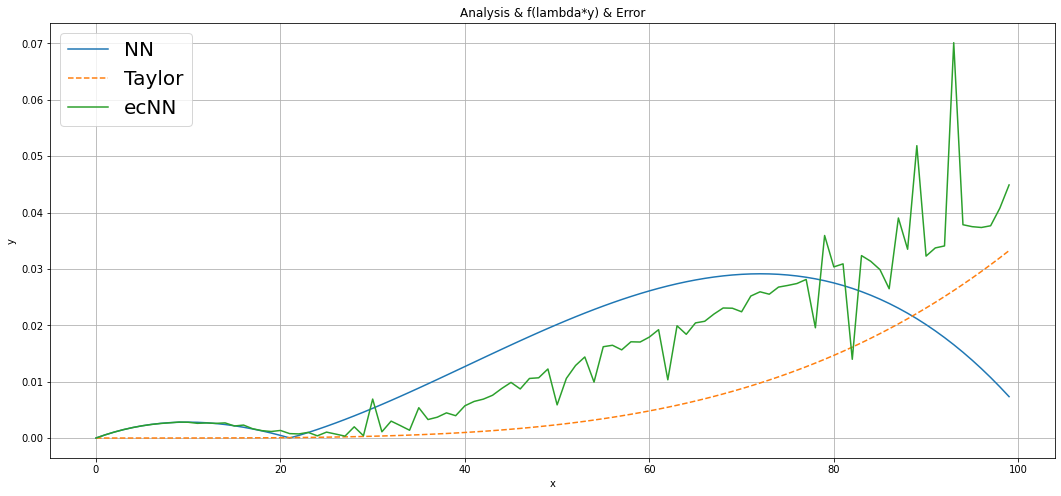

In [ ]:
x_max = 1
x_slice = 100
x = tf.Variable(np.array([[i/x_slice] for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
lamb = -1.0

w, W = w3_EC_Case1_train

n = 3

poly_w = [-1, 1/2, -1/6, 1/24, -1/120]

fig, ax = plt.subplots(figsize=(18, 8))
ax.set_title('Analysis & f(lambda*y) & Error')
ax.set_xlabel('x')
ax.set_ylabel('y')
# ax.plot(anal(x,lamb), label = 'Exact')
ax.plot(abs(y(x, w, n) - anal(x,lamb)), label = 'NN')
ax.plot(abs(y(x, poly_w[:n], n) - anal(x,lamb)), '--', label = 'Taylor')
ax.plot(abs(y(x, w, n) + [sigmoid(w0*x_unit)*w1*x_unit**(n+1) for x_unit, w0, w1 in zip(x, *W)] - anal(x,lamb)), label = 'ecNN')

# ax.plot(y(x, w, n)  + EC_predict(W, x, n), label = 'add_EC')
# ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()

In [ ]:
[sigmoid(w0*x_unit)*w1*x_unit**(n+1) for x_unit, w0, w1 in zip(x, *W)]

# for x_unit, w0, w1 in zip(x, *W):
#     print(x_unit, w0, w1)

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.2814763e-08], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-6.611457e-08], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-4.2130267e-07], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.3291287e-06], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-2.1565909e-06], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-9.754244e-06], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.5970956e-05], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-2.5152747e-05], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([3.6228615e-05], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-2.1271475e-05], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.00

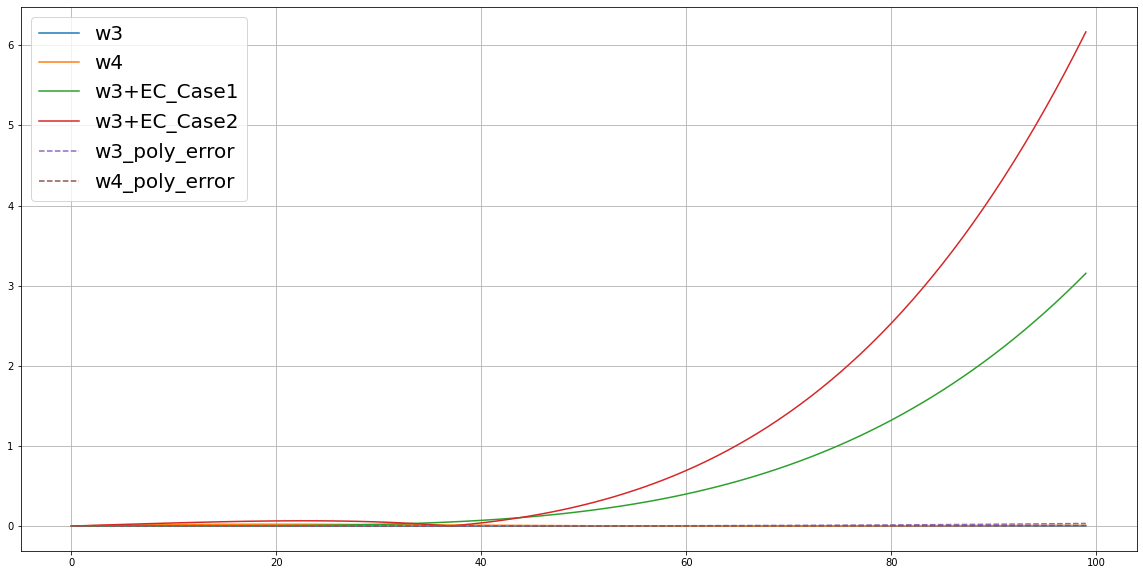

In [ ]:
x_max = 1
x_slice = 100
x = tf.Variable(np.array([[i/x_slice] for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
lamb = -1.0
n = 3

poly_w = [-1, 1/2, -1/6, 1/24, -1/120]

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(abs(y(x, w3_train, 3) - anal(x,lamb)), label = 'w3')
ax.plot(abs(y(x, w4_train, 4) - anal(x,lamb)), label = 'w4')
ax.plot(abs(y(x, w3_EC_Case1_train[0], 3) + EC_predict(w3_EC_Case1_train[1], x, n) - anal(x,lamb)), label = 'w3+EC_Case1')
ax.plot(abs(y(x, w3_EC_Case2_train[0], 3) + EC_predict(w3_EC_Case2_train[1], x, n) - anal(x,lamb)), label = 'w3+EC_Case2')
ax.plot(abs(y(x, poly_w[:3], 3) - anal(x,lamb)), '--', label = 'w3_poly_error')
ax.plot(abs(y(x, poly_w[:4], 4) - anal(x,lamb)), '--', label = 'w4_poly_error')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()

In [90]:
arr = [[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]]


# 상하좌우
delta_row = [-1, 1, 0, 0]
delta_col = [0, 0, -1, 1]

# 상하좌우 한번에 할당
delta_row_col = [[-1, 0], [1, 0], [0, -1], [0, 1], [-1, -1], [-1, 1], [1, 1], [1, -1]]


# 5(1, 1)의 위치를 기준
r = 1
c = 1

for i in range(8):
    next_row, next_col = r + delta_row_col[i][0], c + delta_row_col[i][1]

    print(arr[next_row][next_col])
    # => 2, 8, 4, 6

# 2(0, 1)의 위치를 기준
r = 0
c = 1
print('--')
for i in range(8):
    next_row, next_col = r + delta_row_col[i][0], c + delta_row_col[i][1]

    # print(arr[next_row][next_col])
    # => 8, 5, 1, 3
    # 8의 경우 음수 인덱스 또한 파이썬에서는 출력하기 때문
    # 그렇기 때문에 다음과 같이 조건 지정

    N = len(arr) # 행 / 열의 길이
    if next_row < 0 or next_row >= N or next_col < 0 or next_col >= N:
        continue
    print(arr[next_row][next_col])

2
8
4
6
1
3
9
7
--
5
1
3
6
4


In [96]:
def test():
    global answer
    answer = 1


answer = 0
test()

print(answer)

1
